<a href="https://colab.research.google.com/github/gunman-vagabond/python_colaboratory/blob/master/gunmanPredictionChainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ガンマン画像の判別AIを作りました。の Chainer版

ガンマン・ウルトラマン・仮面ライダー・プリキュアを判別します。

# 画像の学習は事前に行っています。

学習データとしては、googleの画像検索で、以下を準備しました。

*  ガンマン : 400枚
*  ウルトラマン : 400枚
* 仮面ライダー : 400枚
* プリキュア : 400枚

以下のような、ガンマン画像でトレーニングをしました。

https://www.google.com/search?q=%E3%82%AC%E3%83%B3%E3%83%9E%E3%83%B3&rlz=1C1WPZC_enJP815JP819&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiN64qBopngAhUEU7wKHWq6DzsQ_AUIDigB&biw=1249&bih=560


chainerで学習をして、学習済データ(npz)を取得し、外部ファイルに保存をしました。

学習器は、以下に置いています。

https://github.com/gunman-vagabond/python_colaboratory/blob/master/gunmanRecognitionChainer.ipynb


# 学習済データ(npz)を、持ってきます。

In [32]:
!wget http://fc.jpn.org/ryuba/gunman/Chainer/gunmanRecognitionChainer/gunmanChainer.npz -O gunmanChainer.npz
!ls -la

--2019-03-12 16:55:46--  http://fc.jpn.org/ryuba/gunman/Chainer/gunmanRecognitionChainer/gunmanChainer.npz
Resolving fc.jpn.org (fc.jpn.org)... 59.106.13.159
Connecting to fc.jpn.org (fc.jpn.org)|59.106.13.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80155405 (76M)
Saving to: ‘gunmanChainer.npz’

gunmanChainer.npz   100%[===================>]  76.44M  3.37MB/s    in 34s     

2019-03-12 16:56:21 (2.23 MB/s) - ‘gunmanChainer.npz’ saved [80155405/80155405]

total 78356
drwxr-xr-x 1 root root     4096 Mar 12 16:05 .
drwxr-xr-x 1 root root     4096 Mar 12 14:24 ..
drwxr-xr-x 4 root root     4096 Mar  8 17:25 .config
-rw-r--r-- 1 root root 80155405 Mar 12 16:53 gunmanChainer.npz
-rw-r--r-- 1 root root    49815 Jul  9  2018 imageData.bin
drwxr-xr-x 1 root root     4096 Mar  8 17:26 sample_data


# Chainer で、モデルを定義(学習時と同じもの)し、学習データ(npz)をロードします。

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Variable,Chain,optimizers,serializers,datasets

import numpy as np
import matplotlib.pyplot as plt

from chainer.datasets import tuple_dataset
from chainer import training, iterators
from chainer.training import extensions

from sklearn.model_selection import train_test_split
from PIL import Image
import glob


class Alex(Chain):
	# AlexNet
	def __init__(self):
	    super(Alex, self).__init__(
	        conv1 = L.Convolution2D(n_channel, 96, 11, stride=4),
	        conv2 = L.Convolution2D(96, 256, 5, pad=2),
	        conv3 = L.Convolution2D(256, 384, 3, pad=1),
	        conv4 = L.Convolution2D(384, 384, 3, pad=1),
	        conv5 = L.Convolution2D(384, 256, 3, pad=1),
	        fc6 = L.Linear(None, 4096),
	        fc7 = L.Linear(4096, 4096),
	        fc8 = L.Linear(4096, n_label),
	    )

	def __call__(self, x):
		h = F.max_pooling_2d(F.local_response_normalization(
		    F.relu(self.conv1(x))), 3, stride=2)
		h = F.max_pooling_2d(F.local_response_normalization(
		    F.relu(self.conv2(h))), 3, stride=2)
		h = F.relu(self.conv3(h))
		h = F.relu(self.conv4(h))
		h = F.max_pooling_2d(F.relu(self.conv5(h)), 2, stride=2)
		h = F.dropout(F.relu(self.fc6(h)))
		h = F.dropout(F.relu(self.fc7(h)))
		return self.fc8(h)

class DeepLearningClassifier:
	def __init__(self):
		model = Alex()
		self.model = L.Classifier(model)
		self.opt = optimizers.Adam()
		self.opt.setup(self.model)

	def fit(self,X_train, y_train):
		train_data = tuple_dataset.TupleDataset(X_train, y_train)
		train_iter = chainer.iterators.SerialIterator(train_data, batch_size)
		updater = chainer.training.StandardUpdater(train_iter, self.opt)
		self.trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='result')
		self.trainer.extend(extensions.LogReport())
		self.trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy']))
		self.trainer.extend(extensions.ProgressBar())
		self.trainer.run()

	def fit_and_score(self, X_train, y_train, X_test, y_test):
		train_data = tuple_dataset.TupleDataset(X_train, y_train)
		test_data = tuple_dataset.TupleDataset(X_test, y_test)
		train_iter = chainer.iterators.SerialIterator(train_data, batch_size)
		test_iter = chainer.iterators.SerialIterator(test_data, batch_size, repeat=False, shuffle=False)
		updater=chainer.training.StandardUpdater(train_iter, self.opt)
		self.trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='result')
		self.trainer.extend(extensions.Evaluator(test_iter, self.model))
		self.trainer.extend(extensions.LogReport())
		self.trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))
		self.trainer.extend(extensions.ProgressBar())
		self.trainer.run()

	def predict(self, X_test):
		x=Variable(X_test)
		y=self.model.predictor(x)
		answer=y.data
		answer=np.argmax(answer, axis=1)
		return answer

	def score(self, X_test, y_test):
		y=self.predict(X_test)
		N=y_test.size
		return 1.0-np.count_nonzero(y-y_test)/N

	def predict_proba(self, X_test):
		x=Variable(X_test)
		y=self.model.predictor(x)
		y=np.exp(y.data)
		H=y.sum(1).reshape(-1,1)
		return np.exp(y)/H


# モデル設定
batch_size = 100  # バッチサイズ
#n_epoch = 100  # エポック数
n_channel = 3  # channel数（画像の奥行的な。カラー画像ならRGBなので3、モノクロなら1）
n_label = 4  # 正解ラベルの種類数


#model = Alex()
clf = DeepLearningClassifier()
#a = clf.model
#print (a)
serializers.load_npz("gunmanChainer.npz", clf.model)

# 判定したい画像データを、URL指定します。

ガンマン・ウルトラマン・仮面ライダー・プリキュアの画像を指定します。

In [0]:
#imageDataURL="https://animeanime.jp/imgs/p/jtKDOVlKAvjRrNw8SXAVejagI61Nrq_oqaqr/146856.jpg"
imageDataURL="http://fc.jpn.org/ryuba/gunman/pic/Gunman.jpg"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/pic/GunmanProfileIcon.png"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/Illust.ultraman.50.jpg"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/Illust.rider.50.jpg"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/Illust.precure.50.jpg"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/Illust.ultraman2.png"


#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/Illust.ultraman3.jpg"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/Illust.rider3.jpg"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/Illust.precure3.jpg"
#imageDataURL="https://shop.r10s.jp/auc-toysanta/cabinet/040her020/bs-3vfn000kjh-004.jpg"

#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/ultraman4.jpg"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/rider4.jpg"
#imageDataURL="http://fc.jpn.org/ryuba/gunman/keras/gunmanRecognition/precure4.jpg"

#imageDataURL="https://img.animatetimes.com/2018/12/01samune.jpg"
#imageDataURL="https://bandai-a.akamaihd.net/bc/images/shop_top_megatrea/images/0920UA_rider01.jpg"

#imageDataURL="http://www.toei-anim.co.jp/tv/precure/images/top/p_mainv.png"

#imageDataURL="http://fc.jpn.org/ryuba/gunman/pic/gunrobo.MMD.pose.jpg"


# 画像データをダウンロードします。

In [75]:
!wget {imageDataURL} -O imageData.bin

--2019-03-12 17:08:43--  http://fc.jpn.org/ryuba/gunman/pic/Gunman.jpg
Resolving fc.jpn.org (fc.jpn.org)... 59.106.13.159
Connecting to fc.jpn.org (fc.jpn.org)|59.106.13.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9591 (9.4K) [image/jpeg]
Saving to: ‘imageData.bin’

imageData.bin       100%[===================>]   9.37K  --.-KB/s    in 0.09s   

2019-03-12 17:08:43 (105 KB/s) - ‘imageData.bin’ saved [9591/9591]



# 画像を読み込みます。

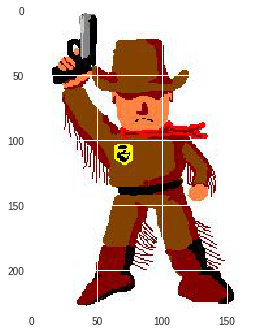

In [76]:
image = Image.open("imageData.bin")

import matplotlib.pyplot as plt
from matplotlib import cm

plt.imshow(image)
plt.show()

# 判定をします。

50x50のサイズにして、
ガンマン率、を判定します。

predict ret: [0]  (gunman, ultraman, rider, precure)


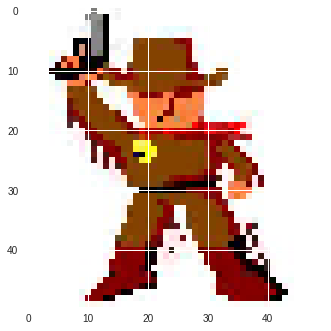

I think this image is a 'gunman'.


In [77]:
image_size = 50
image = image.convert("RGB")
image = image.resize((image_size, image_size))
data = np.asarray(image)

X = []
X.append(data)
X = np.array(X)

X = X.astype('float32')
X = X / 255.0

X = X.reshape(len(X), 3, 50, 50)


ret = clf.predict(X)
print("predict ret:", ret , " (gunman, ultraman, rider, precure)")

import matplotlib.pyplot as plt
from matplotlib import cm

#plt.imshow(X.reshape(50, 50), cmap=cm.gray_r)
plt.imshow(image, cmap=cm.gray_r)
plt.show()

#bestscore = 0.0
#bestnum = 0
#for n in [0,1,2,3]:
#    if bestscore < ret[0][n]:
#        bestscore = ret[0][n]
#        bestnum = n
#

category = ["gunman", "ultraman", "rider", "precure"]
        
print("I think this image is a '" + category[ret[0]] + "'." )
#+ "  (" + str(bestscore*100) + "%)")